github: https://github.com/xuwu201775312/GEOG5990M_final_task.git

In [1]:
# install necessary packages
!pip install contextily
!pip install geoplot
!pip install mapclassify

# import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from scipy import stats

# set Seaborn plotting theme
sns.set_theme(style="white")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.3 MB/s eta 0:00:00


In [2]:
# read dataset
lsoa_data = pd.read_csv('/content/lsoa-data.csv')
lsoa_crime_london = pd.read_csv('/content/lsoa-crime-london.csv')

# summarize crime data by LSOA code
crime_summary = lsoa_crime_london.groupby('LSOA Code')['Crime Count'].sum().reset_index()
crime_summary.columns = ['LSOA Code', 'Total Crime Count']

# merge LSOA data with crime data, retaining all LSOA records
merged_data = pd.merge(lsoa_data, crime_summary, left_on='Lower Super Output Area', right_on='LSOA Code', how='left')

# Set missing values in crime data to zero
merged_data['Total Crime Count'].fillna(0, inplace=True)

merged_data.head()



,Lower Super Output Area,Names,Mid-year Population Estimates;All Ages;2001,Mid-year Population Estimates;All Ages;2002,Mid-year Population Estimates;All Ages;2003,Mid-year Population Estimates;All Ages;2004,Mid-year Population Estimates;All Ages;2005,Mid-year Population Estimates;All Ages;2006,Mid-year Population Estimates;All Ages;2007,Mid-year Population Estimates;All Ages;2008,...,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total,LSOA Code,Total Crime Count
0,E01000907,Camden 001A,1519,1538,1528,1547,1593,1492,1455,1457,...,0,0,0,0,0,0,0,0,E01000907,150
1,E01000908,Camden 001B,1547,1577,1605,1637,1629,1598,1605,1526,...,0,1,0,1,0,0,0,0,E01000908,168
2,E01000909,Camden 001C,1600,1598,1618,1634,1610,1635,1615,1584,...,0,1,1,2,0,1,2,3,E01000909,154
3,E01000912,Camden 001D,1738,1728,1678,1707,1710,1669,1645,1618,...,0,1,10,11,0,0,7,7,E01000912,308
4,E01000913,Camden 001E,1617,1676,1662,1714,1705,1690,1716,1657,...,0,1,6,7,0,1,13,14,E01000913,522


In [3]:
# Check data and preprocess data
# Check data type and convert inappropriate data types
merged_data.dtypes
merged_data['Total Crime Count']=merged_data['Total Crime Count'].astype(int)
# Check for missing values, but no missing values detected
merged_data.isnull().sum()

Lower Super Output Area                        0
Names                                          0
Mid-year Population Estimates;All Ages;2001    0
Mid-year Population Estimates;All Ages;2002    0
Mid-year Population Estimates;All Ages;2003    0
                                              ..
Road Casualties;2014;Serious                   0
Road Casualties;2014;Slight                    0
Road Casualties;2014;2014 Total                0
LSOA Code                                      0
Total Crime Count                              0
Length: 279, dtype: int64

In [4]:
# identify variables for analyzing the best location for the new supermarket, analyze correlations, extract relevant variables to create a new dataset for analysis, and standardizevariables using Z-score

# extract variables related to the total number of traffic accidents
accident_columns = [
    'Road Casualties;2010;2010 Total',
    'Road Casualties;2011;2011 Total',
    'Road Casualties;2012;2012 Total',
    'Road Casualties;2013;2013 Total',
    'Road Casualties;2014;2014 Total'
]

# calculate the average total number of traffic accidents for each LSOA and round to the nearest integer
merged_data['Average Road Casualties 2010-2014'] = merged_data[accident_columns].mean(axis=1).round().astype(int)

# view the first few rows of the new variables
merged_data[['Lower Super Output Area', 'Average Road Casualties 2010-2014']].head()

# extract the list of variables to be analyzed
columns_to_analyze = [
    'Population Density;Persons per hectare;2013',
    'Economic Activity;Employment Rate;2011',
    'Household Income, 2011/12;Median Annual Household Income estimate (?',
    'Health;Very good or Good health (%);2011',
    'Public Transport Accessibility Levels (2014);Average Score;',
    'Average Road Casualties 2010-2014',
    'Total Crime Count'
]

# calculate the correlation of the relevant variables
domains_corr =merged_data[columns_to_analyze].corr(method = 'spearman')
domains_corr

# standardize the variables
# create a StandardScaler object
scaler = StandardScaler()

# Standardizethe specified columns
merged_data[columns_to_analyze] = scaler.fit_transform(merged_data[columns_to_analyze])

# view the standardized data
merged_data[columns_to_analyze].head()



,Population Density;Persons per hectare;2013,Economic Activity;Employment Rate;2011,"Household Income, 2011/12;Median Annual Household Income estimate (?",Health;Very good or Good health (%);2011,Public Transport Accessibility Levels (2014);Average Score;,Average Road Casualties 2010-2014,Total Crime Count
0,0.602306,-0.445196,-0.482904,-1.431090,0.534236,-0.606889,-0.340333
1,-0.073721,-0.011529,-0.323550,-1.382087,-0.527121,-0.606889,-0.293713
2,-0.419594,0.386975,1.982120,0.431024,-0.277390,-0.485225,-0.329973
3,-1.268557,-0.421754,-0.367010,-1.627102,0.534236,0.366428,0.068883
4,-1.378608,1.101938,3.252333,1.411083,-0.589553,0.244764,0.623138


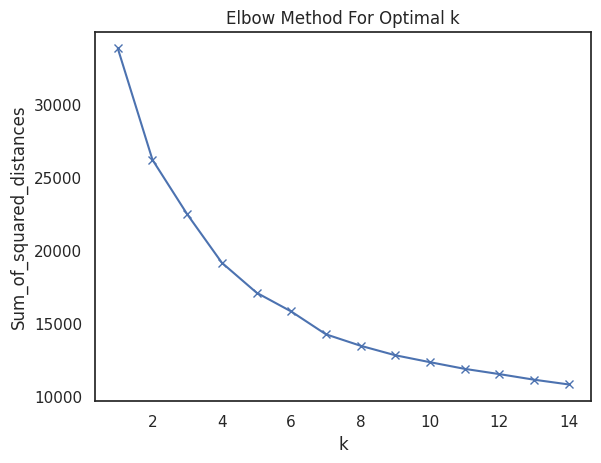

In [5]:
# determine the optimal number of clusters

# create an empty list to fill with values later
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15
for k in K:
    # create a k-means model with that number of clusters
    # set random state
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables of interest (in this case the 7 PPFI domain deciles)
    km = km.fit(merged_data[columns_to_analyze].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list we created earlier
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
# run the model with 5 clusters
km5 = cluster.KMeans(n_clusters=5,init="k-means++",max_iter=300,n_init=50,random_state=123)
km5cls= km5.fit(merged_data[columns_to_analyze].values)
merged_data['Cluster'] = km5cls.labels_
merged_data['Cluster'].head()

# calculate the features of each cluster center
cluster_centers = pd.DataFrame(km5.cluster_centers_, columns=columns_to_analyze)
cluster_centers['Cluster'] = range(5)
# calculate the number of data points in each cluster
cluster_counts = merged_data['Cluster'].value_counts().sort_index()
# calculate the distance of each data point to its cluster center
distances = np.min(km.transform(merged_data[columns_to_analyze]), axis=1)
# create a DataFrame tp save distances and cluster labels
distance_df = pd.DataFrame({'Cluster': merged_data['Cluster'], 'Distance': distances})

# covert the data to long format for plotting
cluster_centers_melted = cluster_centers.melt(id_vars='Cluster', var_name='Variable', value_name='Value')





In [12]:
# analyse cluster characteristics
# calculate the standardized values of each variable in each cluster
contribution = cluster_centers.set_index('Cluster')
contribution = contribution.round(3)
# transpose the data to display by clusters
contribution_transposed = contribution.transpose()
# output the contribution results
print("Contribution of Each Variable in Each Cluster (Standardized Values):")
print(contribution_transposed)


Contribution of Each Variable in Each Cluster (Standardized Values):
Cluster                                                 0      1      2  \
Population Density;Persons per hectare;2013        -0.642  1.181 -0.414   
Economic Activity;Employment Rate;2011              0.561 -0.898  0.103   
Household Income, 2011/12;Median Annual Househo...  0.541 -0.702  0.214   
Health;Very good or Good health (%);2011            0.435 -0.574  0.480   
Public Transport Accessibility Levels (2014);Av... -0.621  0.952  1.797   
Average Road Casualties 2010-2014                  -0.211  0.066  3.736   
Total Crime Count                                  -0.293  0.133  4.717   

Cluster                                                 3      4  
Population Density;Persons per hectare;2013        -0.364  0.581  
Economic Activity;Employment Rate;2011             -0.540  1.157  
Household Income, 2011/12;Median Annual Househo... -0.685  1.244  
Health;Very good or Good health (%);2011           -0.682  1.2

In [13]:
# define a mapping from cluster numbers to cluster names
cluster_names = {
    0: "Prosperous Low-Density Area",
    1: "Quiet Low-Income Community",
    2: "High Traffic and Crime Area",
    3: "Low-Income Low-Access Area",
    4: "Affluent High-Density Area"
}

# map cluster numbers to cluster names
merged_data['Cluster_name'] = merged_data['Cluster'].map(cluster_names)

# check the modified data
print(merged_data[['Cluster', 'Cluster_name']].head())


   Cluster                 Cluster_name
0        1   Quiet Low-Income Community
1        3   Low-Income Low-Access Area
2        0  Prosperous Low-Density Area
3        3   Low-Income Low-Access Area
4        0  Prosperous Low-Density Area


In [14]:
# update the cluster column in the cluster_centers DataFrame
cluster_centers['Cluster_name'] = cluster_centers['Cluster'].map(cluster_names)
cluster_centers_melted = cluster_centers.melt(id_vars=['Cluster', 'Cluster_name'], var_name='Variable', value_name='Value')

# add the Cluster_name column to the distance_df DataFrame
distance_df['Cluster_name'] = distance_df['Cluster'].map(cluster_names)

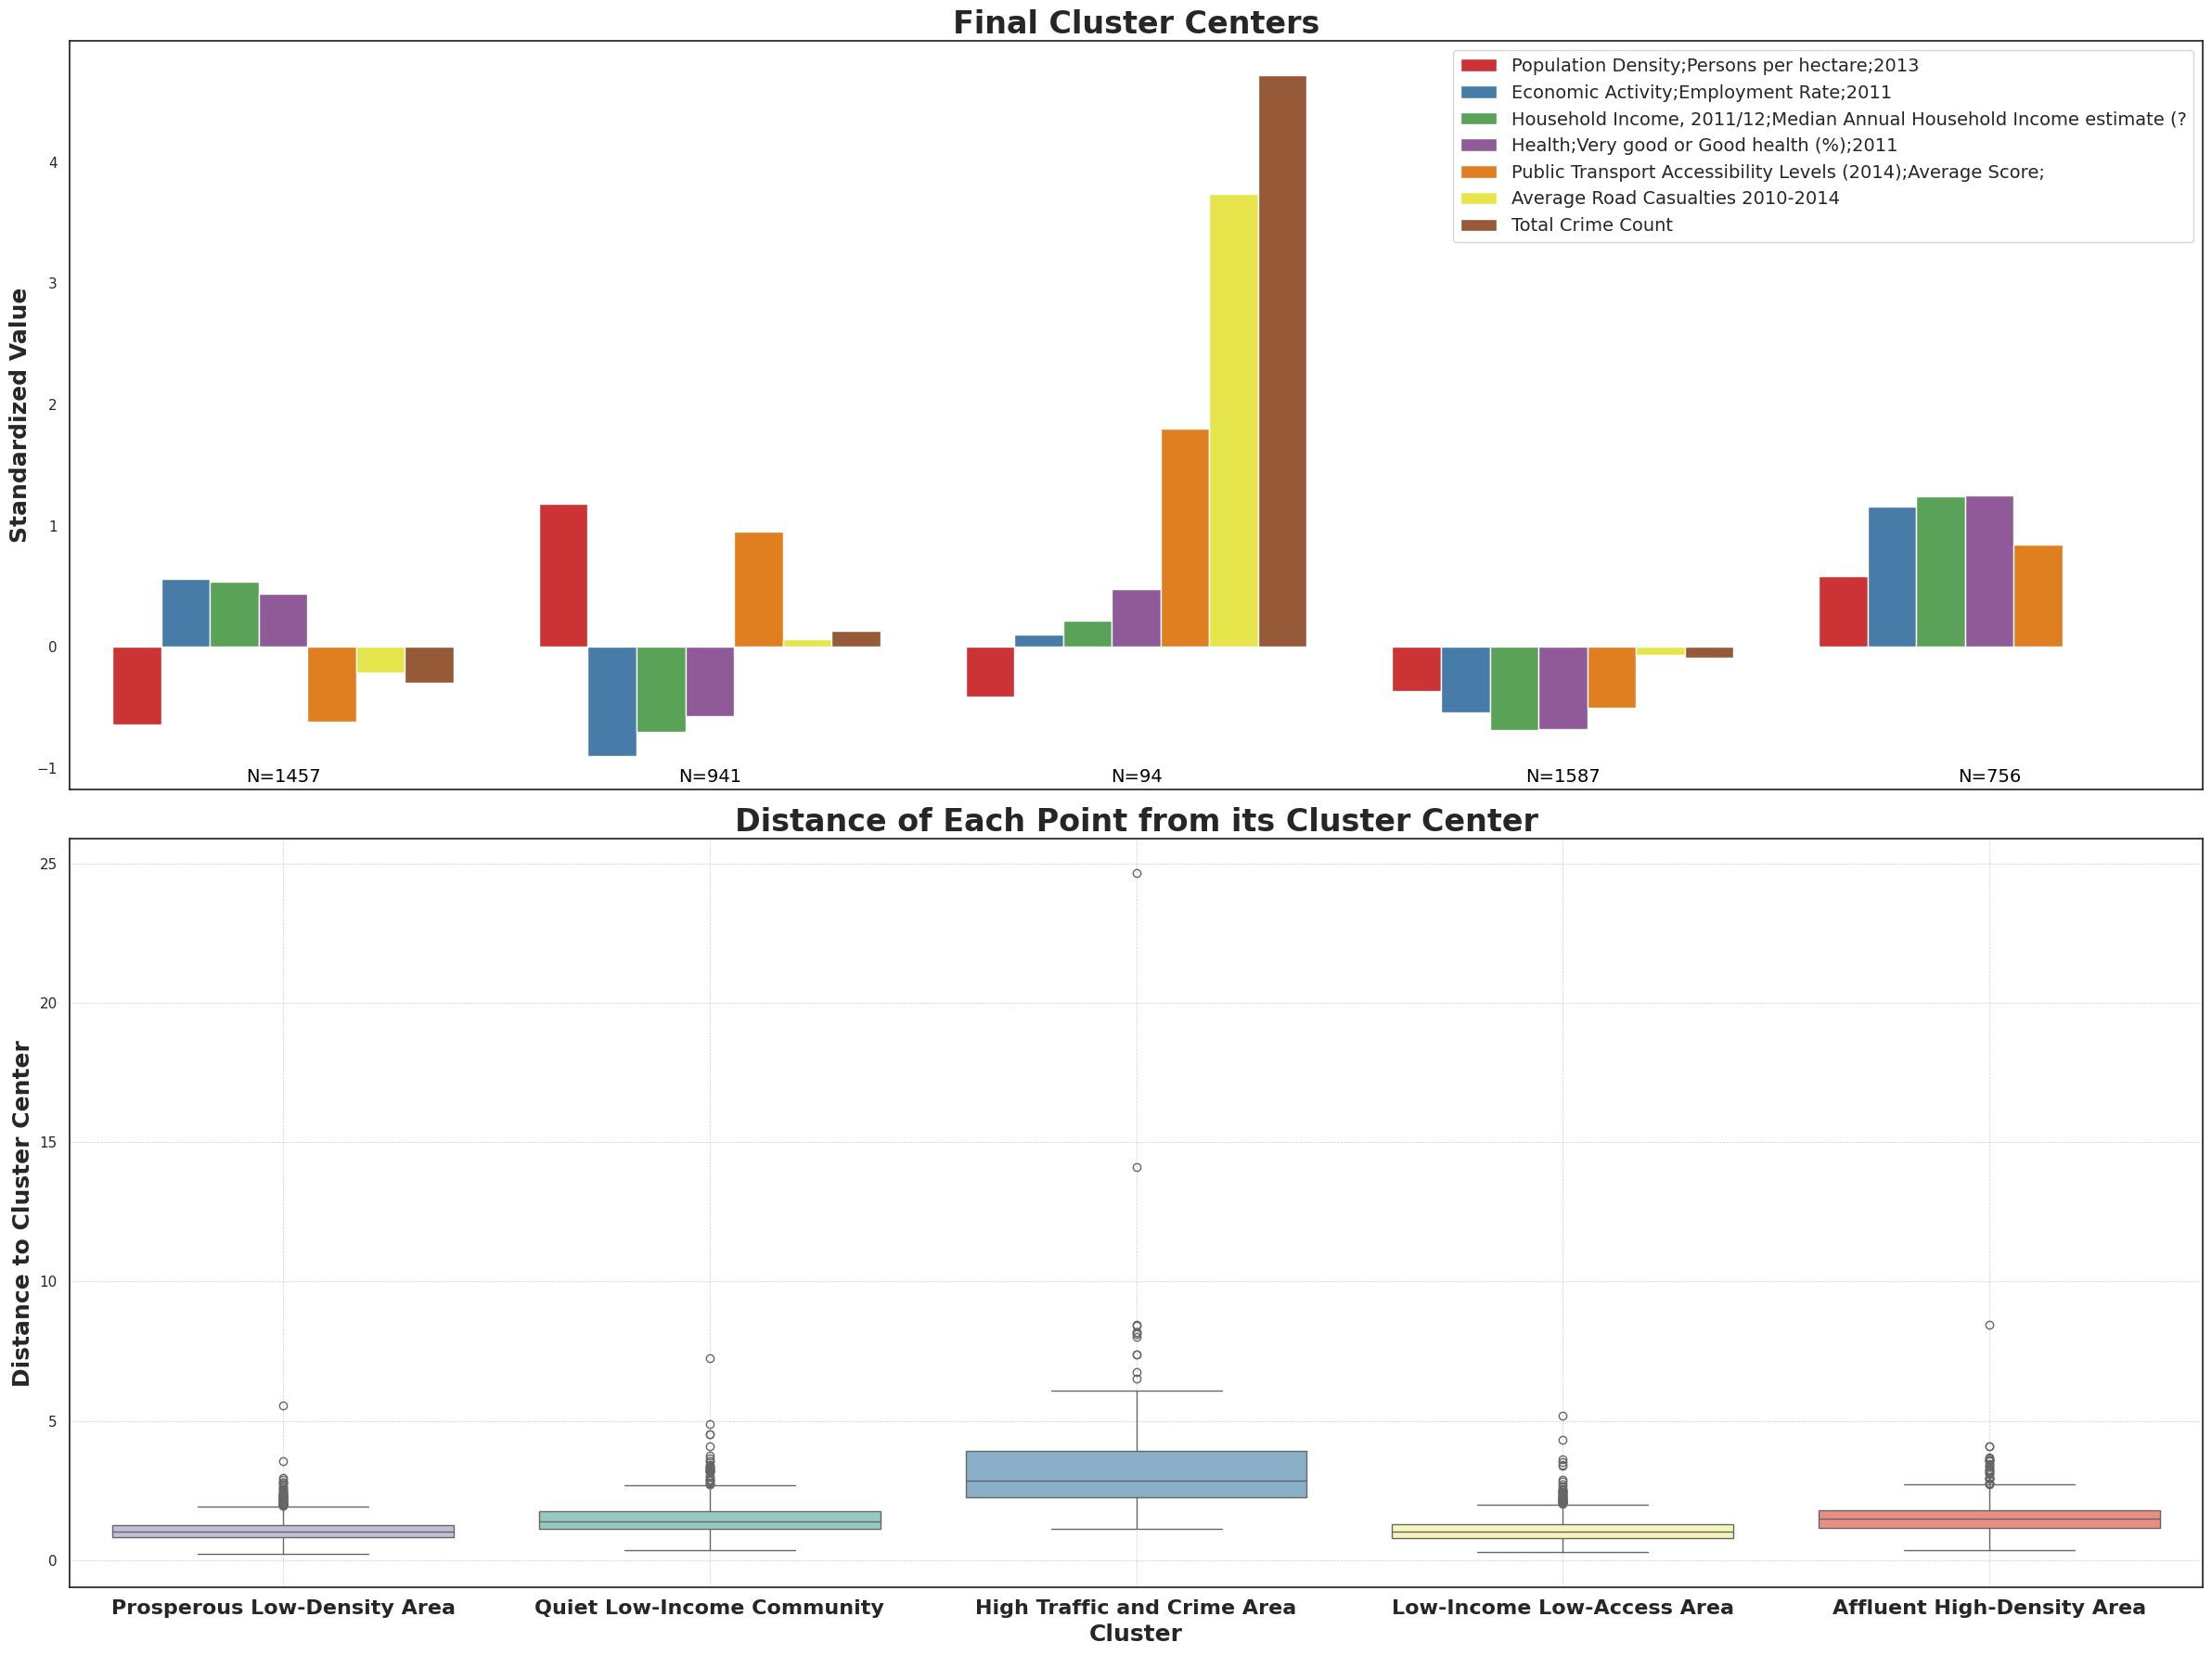

In [15]:
# visualize the clustering results
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(24, 18), gridspec_kw={'height_ratios': [1, 1]})

# plot the cluster center feature chart
sns.barplot(x='Cluster_name', y='Value', hue='Variable', data=cluster_centers_melted, palette=sns.color_palette("Set1", len(columns_to_analyze)), ax=ax0)
ax0.set_title('Final Cluster Centers', fontsize=24, fontweight='bold')
ax0.set_xlabel('')
ax0.set_ylabel('Standardized Value', fontsize=18, fontweight='bold')
ax0.legend(loc='upper right', fontsize=14)
ax0.set_xticklabels([])  # hide X-axis labels as they will be displayed in the next subplot
for i, (name, count) in enumerate(cluster_counts.items()):
    ax0.text(i, -1, f'N={count}', ha='center', va='top', fontsize=14, color='black')

# plot the box plot
sns.boxplot(x='Cluster_name', y='Distance', data=distance_df, palette='Set3', ax=ax1)
ax1.set_title('Distance of Each Point from its Cluster Center', fontsize=24, fontweight='bold')
ax1.set_xlabel('Cluster', fontsize=18, fontweight='bold')
ax1.set_ylabel('Distance to Cluster Center', fontsize=18, fontweight='bold')
ax1.set_xticks(range(len(cluster_names)))
ax1.set_xticklabels(cluster_names.values(), fontsize=16, fontweight='bold', ha='center')
ax1.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [16]:
# visualize the clustering results

# read the data
boundary_london = gpd.read_file('/content/boundary_london1.gpkg')
lsoa_london = gpd.read_file('/content/lsoa_london.gpkg')
uk_car_park = gpd.read_file('/content/uk_car_park.gpkg')

# check the coordinate system
lsoa_london.head()
boundary_london.crs
lsoa_london.crs
uk_car_park.crs

boundary_london = boundary_london.to_crs(epsg=27700)
lsoa_london = lsoa_london.to_crs(epsg=27700)
uk_car_park = uk_car_park.to_crs(epsg=27700)

# merge clustering results into the geographic data
london_cluster = pd.merge(lsoa_london, merged_data, left_on='code', right_on='Lower Super Output Area', how='left')
# clip the parking data to the London boundary
uk_car_park_clipped = gpd.clip(uk_car_park, boundary_london)

# create a GeoDataFrame for geographic visualization
london_cluster_gdf = gpd.GeoDataFrame(london_cluster, geometry='geometry')

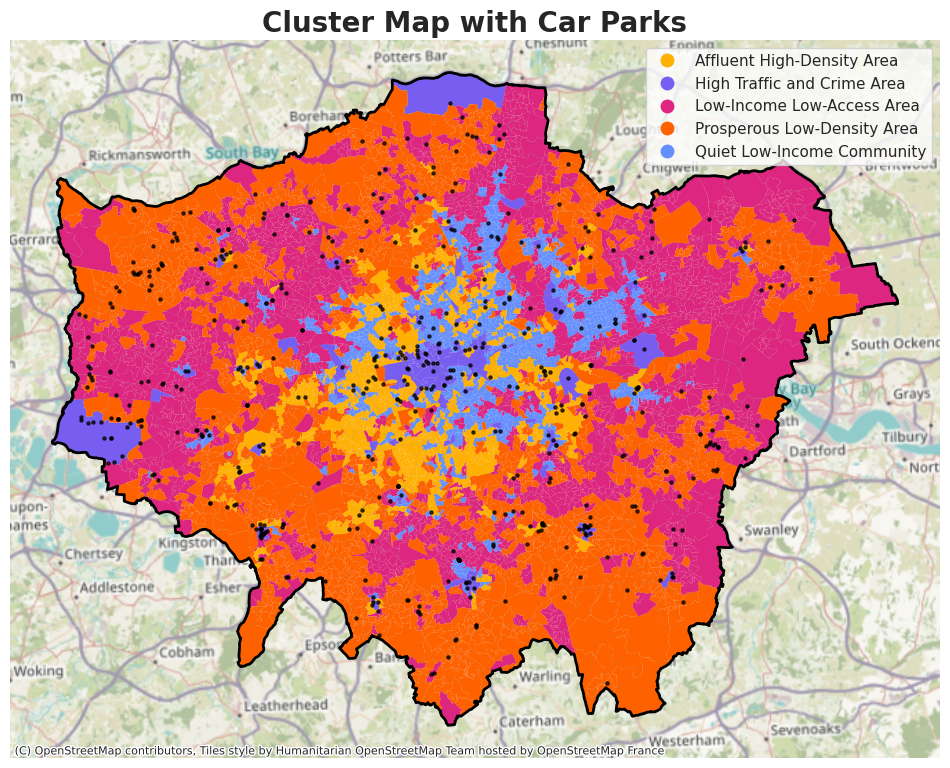

In [17]:
# define a custom color map
my_cmap = ['#FFB000', '#785EF0', '#DC267F', '#FE6100', '#648FFF']

# create the plot
fig, ax = plt.subplots(1, figsize=(12, 12))
# plot the clustering results map using the custom color map
london_cluster_gdf.plot(column='Cluster_name', categorical=True, legend=True,
                        linewidth=0, edgecolor='none', ax=ax, cmap=mcolors.ListedColormap(my_cmap))
# plot the parking data
uk_car_park_clipped.plot(ax=ax, color='black', markersize=5, alpha=0.7)
# plot the London boundary with a bold outline
boundary_london.boundary.plot(ax=ax, linewidth=2, edgecolor='black')
# hide the axes
ax.set_axis_off()
# add titles
ax.set_title('Cluster Map with Car Parks', fontsize=20, fontweight='bold')
# Add basemap
ctx.add_basemap(ax, crs=london_cluster.crs, zorder=0)

# display the chart
plt.show()

In [18]:
# further determine the optimal location for the supermarket

# filter out the areas belonging to the "Affluent High-Density Area"
affluent_high_density_areas = london_cluster_gdf[london_cluster_gdf['Cluster_name'] == 'Affluent High-Density Area']
# check which parking lots are located within these areas
parks_in_affluent_areas = gpd.sjoin(uk_car_park_clipped, affluent_high_density_areas, op='within')
# calculate the number of parkinglots within each code area
parks_count_by_code = parks_in_affluent_areas.groupby('Lower Super Output Area').size()

# filter out the area codes that contain two or more parking lots
codes_with_two_or_more_parks = parks_count_by_code[parks_count_by_code >= 2].index

# retrieve detailed information for these areas
affluent_areas_with_two_or_more_parks = affluent_high_density_areas[affluent_high_density_areas['Lower Super Output Area'].isin(codes_with_two_or_more_parks)]

# print the results
print("Codes of affluent high-density areas with two or more car parks:", codes_with_two_or_more_parks.tolist())


Codes of affluent high-density areas with two or more car parks: ['E01000714', 'E01001519', 'E01001641', 'E01002826', 'E01002914', 'E01003887', 'E01003896', 'E01003939', 'E01032771', 'E01033568', 'E01033731', 'E01033734']


# **Note: Each time the analysis is run, the resulting clusters and the colors on the map may vary slightly, but the overall results remain consistent.**

# **Analysis Objectives**

My objective is to select a viable location in London for a high-end supermarket. I use clustering analysis to identify the target cluster and perform a visual analysis.

Supermarket site selection is crucial for a new supermarket. In a highly competitive market, finding the best location not only identifies the potential area with the highest sales but also effectively enhances the supermarket's competitiveness. Through detailed demographic and geographic analysis, businesses can identify the areas most suitable for high-end supermarkets. These areas have higher spending power and stable customer bases, providing a solid foundation for the supermarket's successful operation (Morrison and Abrahamse, 1996). Additionally, scientific site selection analysis supports marketing strategies and business development plans, ensuring the supermarket can achieve sustained profitability and growth in the future (Morrison and Abrahamse, 1996). Therefore, conducting supermarket site selection analysis is an essential step.

The conditions for supermarket location include: Convenient transportation but low accident rates. High population density and low crime rates. Medium to high household income. Proximity to car parks to ensure convenience, safety, and purchasing power for customers.

# Method Selection

Using K-means clustering can group areas with similar features, identifying regions with market value and different consumer groups. This method helps identify high-potential areas to support supermarket marketing strategies (Kodinariya and Makwana, 2013).

The elbow method determines the optimal number of clusters by calculating the sum of squared errors (SSE) for different K values and plotting the elbow graph to observe the inflection point (Kodinariya and Makwana, 2013).


# Datasets

boundary_london1& lsoa_london: These datasets provide geographic boundaries of London at different administrative levels, useful for mapping and analyzing demographic and socio-economic data. https://ukdataservice.ac.uk/learning-hub/census/other-information/census-boundary-data/

uk_car_park: This dataset contains point data for car parks across the UK. https://hub.arcgis.com/datasets/tfwm::department-for-transport-uk-car-parks/about

lsoa-crime-london: This dataset includes recorded crime data at the LSOA level in London, provided by the University of Glasgow.  Recorded Crime Summary Data for London: LSOA Level - Dataset - UBDC Data Catalogue , None (2023). Recorded Crime Summary Data for London: LSOA Level [Data set]. University of Glasgow. https://doi.org/10.20394/sjpbiv4u

lsoa-data: This dataset encompasses demographic information, including population density, household characteristics, health, housing, crime, and employment at the LSOA level. https://data.london.gov.uk/dataset/lsoa-atlas


# Non-Spatial Data Clustering Results Visualization: Data Processing：

Import the lsoa-crime-london and lsoa-data CSV files.

Check the completeness and consistency of the data; no issues found.

Create New Variable: In lsoa-crime-london, sum different crime categories to create a new variable, crime_count.

Data Merge: Use LSOA code to merge lsoa-crime-london with LSOA data, creating a new dataset, merged_data.

Traffic Incident Variable Processing: In merged_data, sum traffic incident variables from 2010 to 2014 and calculate the average, creating ‘Average Road Casualties 2010-2014’.

Extract Relevant Variables: Extract all variables related to supermarket location selection, forming a list columns_to_analyze.

# Variable Selection:

Population Density (Persons per hectare; 2013): High population density indicates more potential customers and high demand (Ghorui et al., 2020).

Economic Activity (Employment Rate; 2011): Areas with high employment rates typically have a stable economic base and higher consumption capacity (Baviera-Puig et al., 2016).

Household Income (2011/12; Median Annual Household Income estimate): High-income residents have strong purchasing power, supporting high-end supermarket sales (Morrison and Abrahamse, 1996).

Health (Very good or Good health (%); 2011): Residents with good health tend to have a higher quality of life and demand for healthy products (Morrison and Abrahamse, 1996).

Public Transport Accessibility Levels (2014; Average Score): Good public transport accessibility increases supermarket foot traffic and indicates better regional transport conditions (Ghorui et al., 2020).

Average Road Casualties (2010-2014): Low traffic accident rates in safe areas help prevent loss of foot traffic (Baviera-Puig et al., 2016).

Total Crime Count: A safe environment is crucial for attracting customers (Baviera-Puig et al., 2016).

Exploring the correlation between these variables revealed low correlations, which helps avoid redundancy and improves the distinction in clustering results.

# Non-Spatial Clustering Analysis Visualization Results

Determining the Number of Clusters: Based on the elbow method, the optimal number of clusters is 5, indicated by a noticeable bend between 4 and 5 clusters.

K-means Clustering Analysis: Applied k-means clustering to the selected variables. Visualized the distribution of distances from each data point to its cluster center using box plots.

Cluster Results:

Cluster 0 (Prosperous Low Density Area): High income, low crime, inconvenient public transport, low population density.

Cluster 1 (Quiet Low Income Area): High population density and public transport accessibility, low income, slightly higher crime rate.

Cluster 2 (High Traffic and Crime Area): High public transport accessibility, very high traffic accident and crime rates.

Cluster 3 (Low Income No Access Area): Low traffic accident and crime rates, low public transport accessibility, population density, and income.

Cluster 4 (Affluent High Density Area): High public transport accessibility, high population density and income, average traffic accident and crime rates.

Box Plot Characteristics Summary:

Clusters 0, 1, 3, 4: Small box, data points close to the cluster center, well-clustered, good quality, some outliers but not far.

Cluster 2: Large box, data points far from the cluster center, dispersed, poor quality, many distant outliers.

Conclusion:
Cluster 4 is the best cluster for high-end supermarket location.


# Spatial Data Clustering Results Visualization: Data Processing

Import `boundary_London`, `LSOA_London`, and `UK_car_park` data.

Check the coordinate systems and unify them to EPSG:27700.

Merge Geographic and Non-Geographic Data: Use `LSOA code` to merge `merged data` with `LSOA London`, creating a complete dataset `london_cluster_gdf` with geographic information.

Clip Car Park Data: Clip `UK_car_park` point data to the London area.

# Spatial Clustering Analysis Visualization Results:

Use `cluster name` to visualize clusters with different colors. Overlay clipped `UK car park` data on the visualized clusters. Add `boundary_London` with bold lines at the top layer and include a map base layer for background.

Map Distribution Description:

Cluster 4 (Affluent High-Density Area): Yellow, concentrated in central London and surrounding areas.

High Traffic and Crime Area: Purple, mainly in a few central and two peripheral areas.

Low-Income Low-Access Area: Pink, largely in outer London, covering a large area but with fewer car parks.

Prosperous Low-Density Area: Orange, in the outermost regions, especially south and northwest, with fewer car parks, covering a large area.

Quiet Low-Income Community: Blue, mainly in central London, small coverage area with moderate car parks.

Further Analysis to Determine Optimal Supermarket Locations:

Focus on Cluster 4 (Affluent High-Density Area).

Calculate the number of car parks in each area within this cluster.

Filter areas with at least 2 car parks for better customer convenience and attraction.

The final analysis identifies these areas as optimal for a high-end supermarket location: 'E01000714', 'E01001519', 'E01001641', 'E01002826', 'E01002914', 'E01003887', 'E01003896', 'E01003939', 'E01032771', 'E01033568', 'E01033731', 'E01033734'.


# Reference:

Baviera-Puig, A., Buitrago-Vera, J. and Escriba-Perez, C. 2016. Geomarketing models in supermarket location strategies. Journal of Business Economics and Management. 17(6), pp.1205–1221.

Ghorui, N., Ghosh, A., Algehyne, E.A., Mondal, S.P. and Saha, A.K. 2020. AHP-TOPSIS Inspired Shopping Mall Site Selection Problem with Fuzzy Data. Mathematics. 8(8), p.1380.

Kodinariya, T. and Makwana, P. 2013. Review on Determining of Cluster in K-means Clustering. International Journal of Advance Research in Computer Science and Management Studies. 1, pp.90–95.

Morrison, P.A. and Abrahamse, A.F. 1996. Applying demographic analysis to store site selection. Population Research and Policy Review. 15(5), pp.479–489.
